使用Pytorch对非线性数据进行分类
===

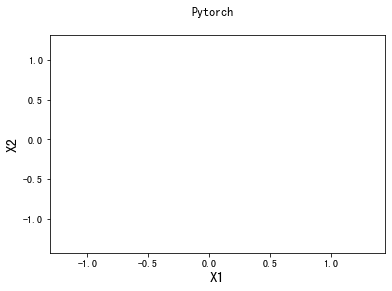

In [14]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import torch

import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from torch.autograd import Variable
from sklearn.datasets import make_circles
STEPS = 30000
DECAY_STEP = 100

cm_light = mpl.colors.ListedColormap(['#A0FFA0', '#FFA0A0'])
cm_dark = mpl.colors.ListedColormap(['g', 'r'])

x_data, y_data = make_circles(n_samples=200, noise=0.2, factor=0.1)

x_data = pd.DataFrame(x_data)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=1)

x_train = torch.FloatTensor(x_train.values[:])
y_train = torch.LongTensor(y_train)

x, y = Variable(x_train), Variable(y_train)

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.out = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.out(x)
        return x

net = Net(n_feature=2, n_hidden=10, n_output=2)     # define the network

optimizer = torch.optim.RMSprop(net.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted

predict = []
myloss = []
N, M = 50,50 # 横纵各采样多少个值
x1_min, x2_min = x_data.min()
x1_max, x2_max = x_data.max()
t1 = np.linspace(x1_min, x1_max, N)
t2 = np.linspace(x2_min, x2_max, M)
x1, x2 = np.meshgrid(t1, t2)  # 生成网格采样点
x_show = np.stack((x1.flat, x2.flat), axis=1)  # 测试点

for step in range(STEPS):
    out = net(x)                 # input x and predict based on x
    loss = loss_func(out, y)     # must be (1. nn output, 2. target), the target label is NOT one-hotted

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients

    _, prediction = torch.max(F.softmax(out, dim=None), 1)
    pred_y = prediction.data.numpy().squeeze()
    target_y = y.data.numpy()
    accuracy = sum(pred_y == target_y)/x.shape[0]

    if (step + 1) % DECAY_STEP == 0:
        out = net(Variable(torch.FloatTensor(x_show)))
        _, prediction = torch.max(F.softmax(out, dim=None), 1)
        pred_y = prediction.data.numpy().squeeze()
        predict.append(pred_y)
        myloss.append(loss.item())

fig, axes = plt.subplots()
plt.xlabel("X1", fontsize=15)
plt.ylabel("X2", fontsize=15)
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.suptitle("Pytorch")
time_template = 'step = %d, train loss=%.9f'

def animate(i):
    plt.title(time_template % (i * DECAY_STEP, myloss[i]))
    plt.pcolormesh(x1, x2, predict[i].reshape(x1.shape), cmap=cm_light)
    plt.scatter(x_data[0], x_data[1], c=y_data.ravel(), edgecolors='k', s=40, cmap=cm_dark)


# anim = animation.FuncAnimation(fig, animate, frames=range(int(STEPS / DECAY_STEP)),
#                                blit=False,interval=50)
# anim.save("02_13_05.gif", writer='imagemagick', fps=100)
# plt.show()


![Images](../../images/14_01_002.gif)